✅ Total samples: 2179, classes: 5

📋 Classification Report:
              precision    recall  f1-score   support

    Ciherang       1.00      1.00      1.00       125
   INPARI_V2       0.96      0.98      0.97       120
        IR64       0.98      0.98      0.98       122
   Rojo Lele       0.99      0.97      0.98       120
  pandawangi       1.00      0.99      1.00       167

    accuracy                           0.99       654
   macro avg       0.99      0.99      0.99       654
weighted avg       0.99      0.99      0.99       654



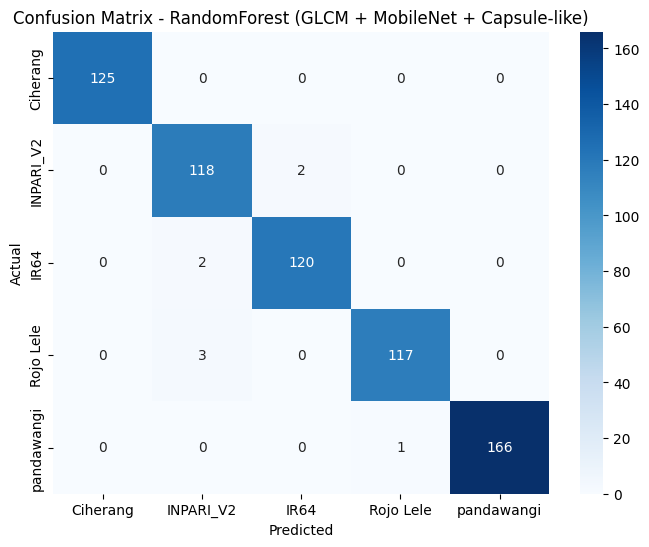

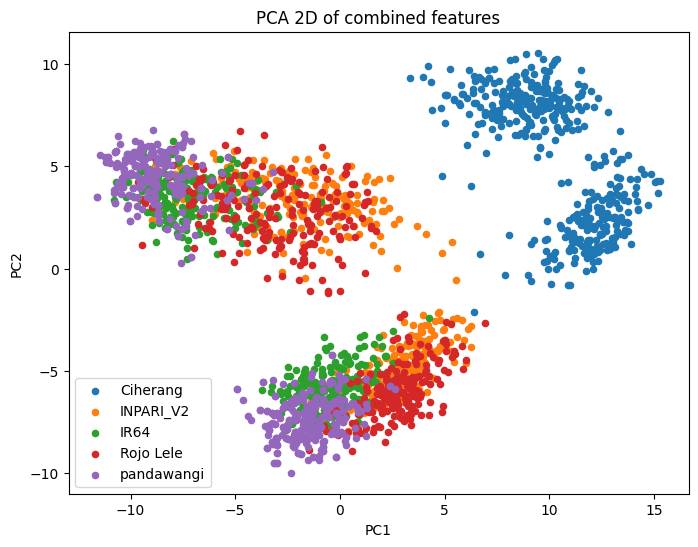

In [8]:
# === IMPORTS ===
import os, math, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# === SETTINGS ===
folder_path = r"C:\Users\Raga Triagantara\Archives\Projects\Program GLCM\GABAH"
IMG_SIZE = (224, 224)
CAPS_NUM = 16   # jumlah "capsules" (akan jadi fitur vector length CAPS_NUM)
CAPS_DIM = 8    # dimensi tiap capsule internal (digunakan untuk compute length)
MOBILENET_FEATURE_DIM = 1280  # default MobileNetV2 pooling='avg' dim

# === 1) BANTUAN PREPROCESS / FUNGSI ===
def grayworld_norm(img):
    B, G, R = cv2.split(img.astype(np.float32))
    mean_R, mean_G, mean_B = np.mean(R), np.mean(G), np.mean(B)
    mean_gray = (mean_R + mean_G + mean_B) / 3.0 + 1e-8
    R = np.clip(R * (mean_gray / (mean_R + 1e-8)), 0, 255)
    G = np.clip(G * (mean_gray / (mean_G + 1e-8)), 0, 255)
    B = np.clip(B * (mean_gray / (mean_B + 1e-8)), 0, 255)
    return cv2.merge([B, G, R]).astype(np.uint8)

def otsu_sinus(hist):
    sum_total = np.dot(np.arange(256), hist)
    best_t, max_sigma = 0, 0
    w0, sum0 = 0.0, 0.0
    for t in range(256):
        w0 += hist[t]
        sum0 += t * hist[t]
        if w0 == 0 or w0 == 1: continue
        w1 = 1.0 - w0
        mu0 = sum0 / w0
        mu1 = (sum_total - sum0) / w1
        sigma_b = w0 * w1 * (math.sin(mu0 - mu1)) ** 2
        if sigma_b > max_sigma:
            max_sigma, best_t = sigma_b, t
    return best_t

def glcm_features(img_bin):
    if img_bin.ndim == 3:
        img_bin = cv2.cvtColor(img_bin, cv2.COLOR_BGR2GRAY)
    levels = 16
    img_q = (img_bin.astype(np.float32) / 256.0 * levels).astype(np.uint8)
    glcm = graycomatrix(img_q, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True, normed=True, levels=levels)
    contrast = graycoprops(glcm, 'contrast').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    return np.array([contrast, correlation, energy, homogeneity], dtype=np.float32)

# === 2) MobileNetV2 feature extractor (pretrained) ===
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
def extract_mobilenet_feature(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    x = mobilenet_preprocess(img_resized.astype(np.float32))
    x = np.expand_dims(x, axis=0)
    feat = mobilenet_model.predict(x, verbose=0)
    return feat.reshape(-1)  # shape (1280,)

# === 3) Capsule-like feature extractor (stable) ===
# Idea: conv -> global avg pool -> dense (n_caps * dim) -> reshape -> compute lengths
def build_capsule_like_extractor(input_shape=(224,224,3), n_caps=CAPS_NUM, dim_caps=CAPS_DIM):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)  # fixed-size vector
    x = layers.Dense(n_caps * dim_caps, activation='relu')(x)
    x = layers.Reshape((n_caps, dim_caps))(x)  # shape (n_caps, dim_caps)
    # compute length (L2 norm) per capsule -> shape (n_caps,)
    lengths = layers.Lambda(lambda z: tf.sqrt(tf.reduce_sum(tf.square(z), axis=-1) + 1e-9))(x)
    model = models.Model(inputs=inp, outputs=lengths, name='capsule_like_extractor')
    return model

capsnet_like_model = build_capsule_like_extractor(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                                  n_caps=CAPS_NUM, dim_caps=CAPS_DIM)

def extract_capsule_like_feature(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    x = img_resized.astype(np.float32) / 255.0
    x = np.expand_dims(x, axis=0)
    feat = capsnet_like_model.predict(x, verbose=0)
    return feat.reshape(-1)  # shape (n_caps,)

# === 4) MAIN: loop dataset, extract features, collect labels ===
X_list = []
y_list = []
failed = []

for label_folder in sorted(os.listdir(folder_path)):
    class_path = os.path.join(folder_path, label_folder)
    if not os.path.isdir(class_path): continue
    for file_name in sorted(os.listdir(class_path)):
        img_path = os.path.join(class_path, file_name)
        img = cv2.imread(img_path)
        if img is None:
            failed.append(img_path)
            continue

        # preprocessing + segmentation
        img_norm = grayworld_norm(img)
        gray = cv2.cvtColor(img_norm, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0,256]).ravel()
        hist_norm = hist / hist.sum() if hist.sum() > 0 else np.ones(256)/256
        t_sin = int(otsu_sinus(hist_norm))
        _, th_sin = cv2.threshold(gray, t_sin, 255, cv2.THRESH_BINARY)
        kernel = np.ones((3,3), np.uint8)
        cleaned = cv2.morphologyEx(th_sin, cv2.MORPH_OPEN, kernel, iterations=2)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

        # features
        f_glcm = glcm_features(cleaned)                     # (4,)
        f_mobilenet = extract_mobilenet_feature(img_norm)    # (1280,)
        f_caps = extract_capsule_like_feature(img_norm)      # (CAPS_NUM,)

        feats = np.concatenate([f_glcm, f_mobilenet, f_caps]).astype(np.float32)
        X_list.append(feats)
        y_list.append(label_folder)

print(f"✅ Total samples: {len(X_list)}, classes: {len(set(y_list))}")
if failed:
    print(f"⚠ Failed read {len(failed)} files (examples): {failed[:3]}")

# === 5) Train/Test split + RandomForest ===
X = np.array(X_list)
y = np.array(y_list)

# If stratify fails due to very small classes, remove stratify argument
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
except Exception as e:
    print("⚠ Stratify failed, fallback split without stratify:", e)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# === 6) Evaluation ===
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels_sorted = np.unique(y)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RandomForest (GLCM + MobileNet + Capsule-like)")
plt.show()

# === 7) PCA visualization ===
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
plt.figure(figsize=(8,6))
for cls in np.unique(y):
    idx = np.where(y == cls)
    plt.scatter(X_2d[idx,0], X_2d[idx,1], label=cls, s=20)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA 2D of combined features")
plt.legend()
plt.show()